This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fchatelaf%2Fml-sicom3a/master?urlpath=lab/tree/notebooks/7_trees_randomforest_boosting/)

WARNING : requires scikit-learn 0.22.0 or above

# COST COMPLEXITY PRUNING of a regression tree

Minimal cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting. It was introduced by BREIMAN in the 1980's. 
The cost complexity measure of a tree $T$ is parameterized by a complexity parameter $\alpha > 0$ : 
$$ C_\alpha(T) = C(T) + \alpha |T| $$
where $C(T)$ is the total impurity measure of the tree, and $|T|$ is the number of subsets in the partition of the observation set, definied by the tree. It is also equal to the number of terminal leaves. The pupose of **minimal cost pruning** is to find a subtree of $T$ that minimizes $C_\alpha$.

Consider a non-terminal node ( i.e. not a leaf), name it $t$. Let $T_t$ be the subtree whose root note is $t$. Let $C(t)$ and $C(T_t)$ be the impurity measure associated with $t$ and $T_t$ respectively. In general $C(t)> C(T_t)$ as the impurity decreases when the depth increases. This is however not the case for $C_\alpha$. 

One has $$C_\alpha(t)= C(t)+\alpha$$ and  $$C_\alpha(T_t)=C(T_t)+\alpha |T_t|$$

Let $\alpha_{eff}$ be the value of $\alpha$ defined by $C_{\alpha_{eff}}(t)= C_{\alpha_{eff}}(T_t)$. A value of $\alpha_{eff}$ is defined for each node. On easily gets
$$ \alpha_{eff} = \frac{C(t)-C(T_t)}{|T_t|-1} $$

The non-terminal **node with the smallest value of $\alpha_{eff}$ is the weakest link and will be pruned**. This process is iterated until the pruned tree’s minimal $\alpha_{eff}$ is greater than some threshold (ccp_alpha in sklearn codes).

More details may be found here
https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sklearn  import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

from IPython.display import Image  
import pydotplus



## Consider  the  same example as in notebook $N2\_a$
The purpose of this is to compare the structures and scores for two tree estimation methods, in the same regression framework as in notebook N2_a_Regression_tree.ipynb.

The first considered strategy consist in fixing the maximal depth of the tree in order to avoid overfitting; the second strategy is a pruning strategy, based on Cost complexity optimization. 

The number of point in the set is 629


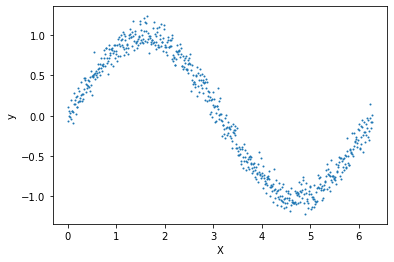

In [2]:
# Building the data set : 
noise_std=.1
X=np.arange(0,2*np.pi,.01)[:,np.newaxis]
nx=np.random.randn(X.shape[0],1)*noise_std
y=np.sin(X)+np.random.randn(X.shape[0],1)*noise_std
print("The number of point in the set is {}".format(len(X)))

plt.figure()
plt.scatter(X,y,s=1)
plt.xlabel('X')
plt.ylabel('y');


### Let's begin by computing a regression tree without fixed depth, nor control on the min number of samples in leaves, and visualize it : 

clf is a regression tree with 15 depths and 125 leaves


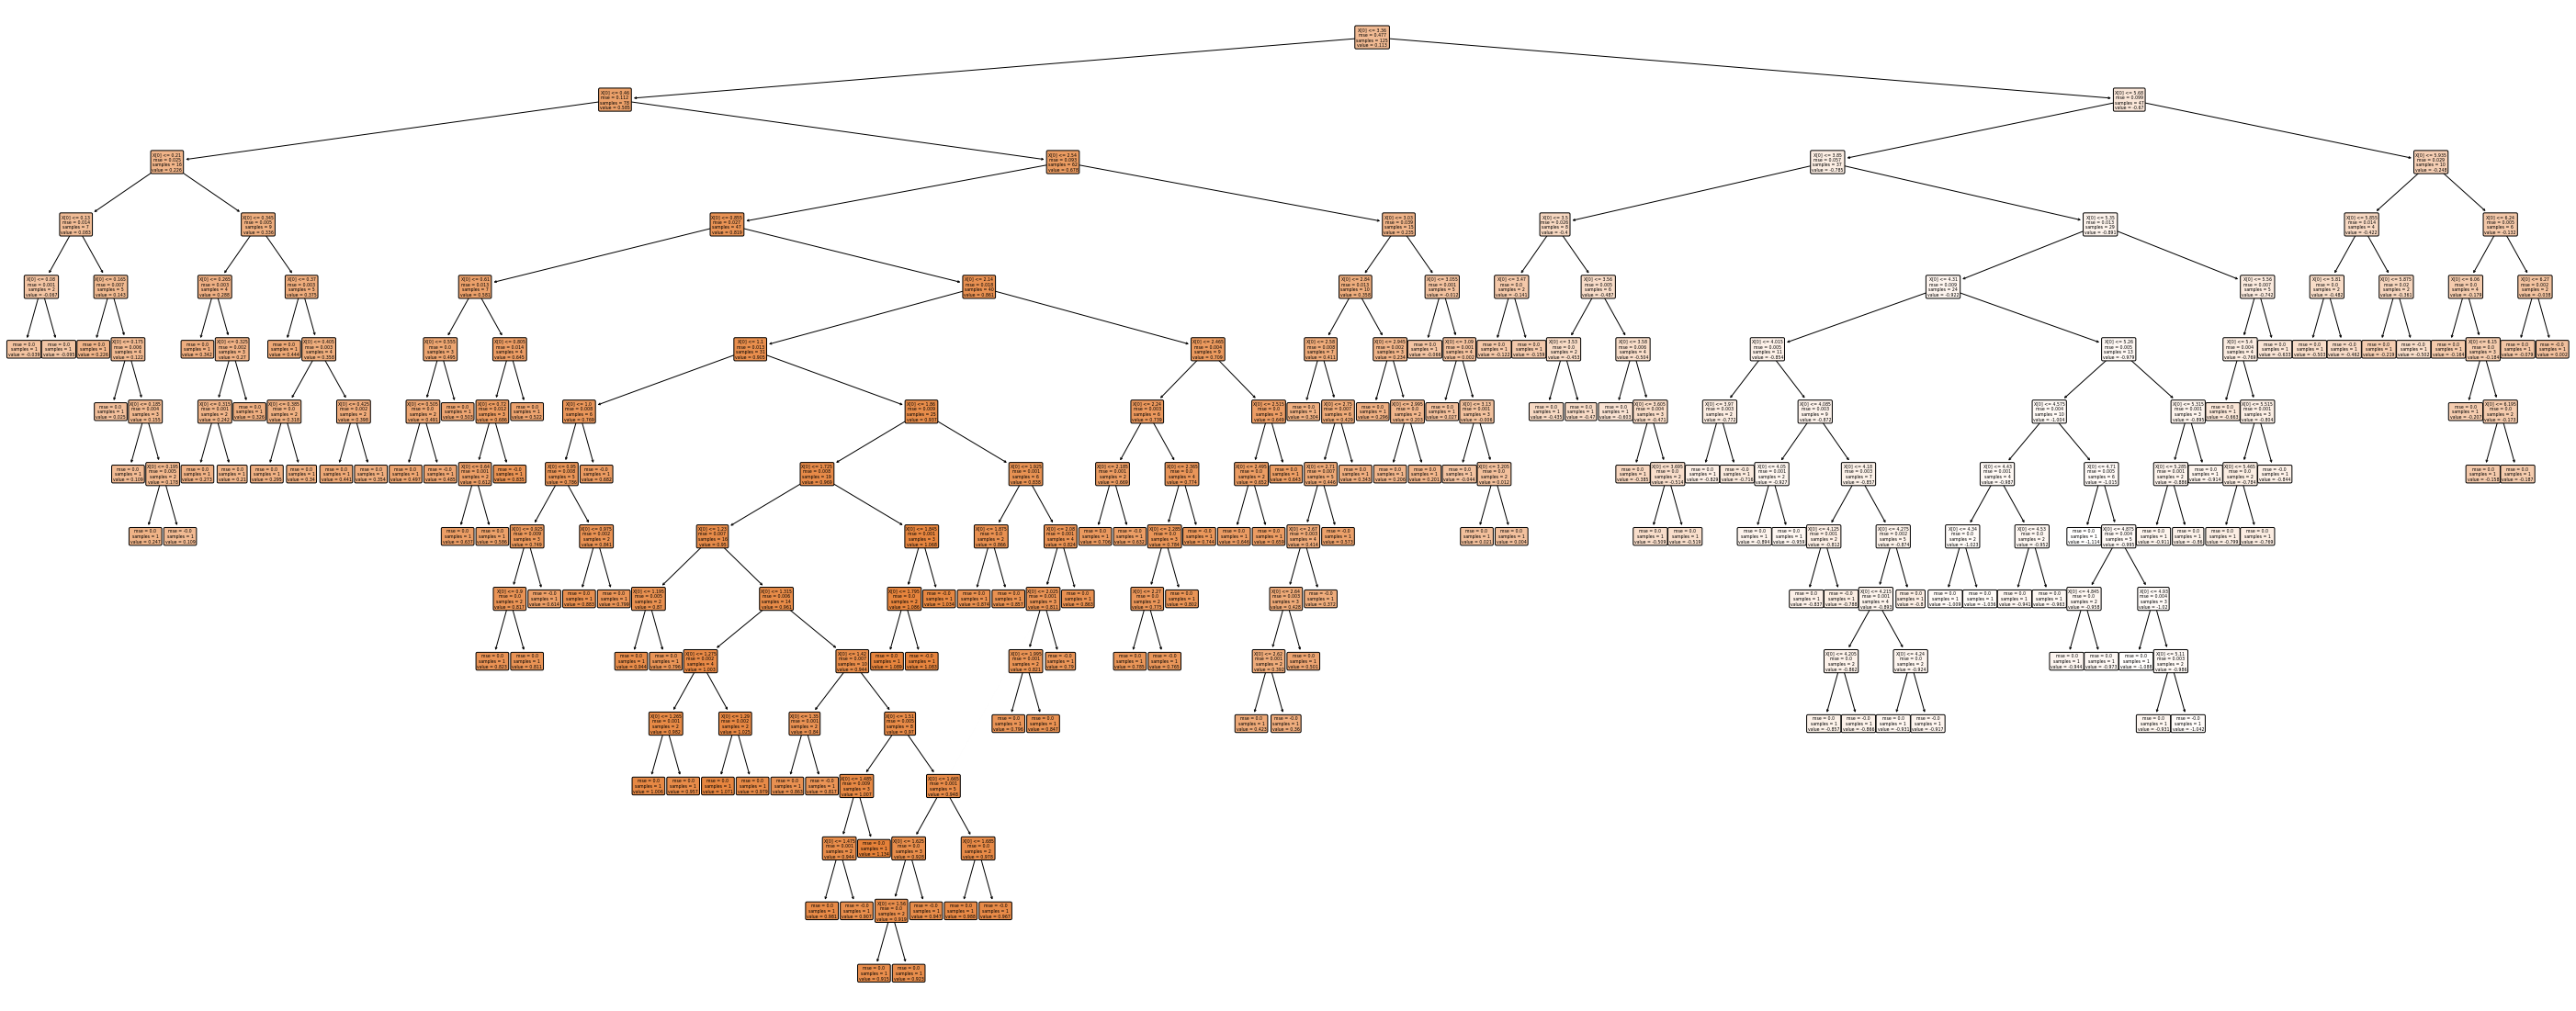

In [3]:
# Make train and test sets :
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=None)
# Define the regressor parameters and structure : (other params take defaul values, 
# see https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
clf = DecisionTreeRegressor(random_state=0, criterion='mse', \
                           splitter='best', \
                           max_depth=None , \
                           min_samples_leaf=1)
# train the regressor : 
clf=clf.fit(X_train,y_train)
print("clf is a regression tree with {} depths and {} leaves".format(clf.get_depth(),clf.get_n_leaves()))

from sklearn.tree import plot_tree

plt.figure(figsize=(50,20))
a = plot_tree(clf, 
              filled=True, 
              rounded=True)

              #fontsize=14)

## Question
- do you think that such a regressor will have good preformances for other noise realizations? Explain. 

## Compute the set of relevant values for the regularization parameter $\alpha$

The method  *cost_complexity_pruning_path*  allows to identify the sequence of values of $\alpha_{eff}$ (see def at the biginning of the document) obtained while recursively pruning the regressor, until a trivial 1-depth tree is obtained (that counts only 3 nodes, including 2 leaves).

Number of relevant values found for alpha_eff :97


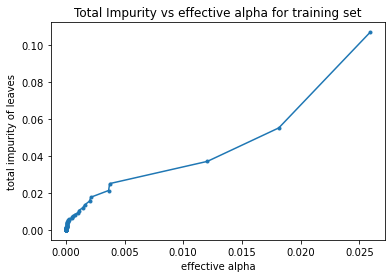

In [4]:
# compute the sequence of alpha(s), and mse of the pruned regressor for corresponding alpha.
path = clf.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# plot the results (the last value corresponding to a trivial tree is discarded)
plt.figure()
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='.')
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")
plt.title("Total Impurity vs effective alpha for training set");

print("Number of relevant values found for alpha_eff :{}".format(len(ccp_alphas)))


## Finding the "best" value for $\alpha$
For each of the values in the sequence of alphas obtained above, a regressor is trained, and stored, then its score (performance) is evaluated on a test set. 

### Making a list of the regressors for different $\alpha$ values

In [5]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(ccp_alpha=ccp_alpha) #all other parameters take their default value
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))
print("Number of nodes in the first tree is: {} with ccp_alpha: {}".format(
      clfs[0].tree_.node_count, ccp_alphas[0]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.369719603539041
Number of nodes in the first tree is: 249 with ccp_alpha: 0.0


## Question
- what is the  regression tree that one obtains for $\alpha = 0$? (explain)
- what is the regression tree that one obtains for very large values of $\alpha$?

### Evaluate the scores of the regressors for the different pruning parameters $\alpha$

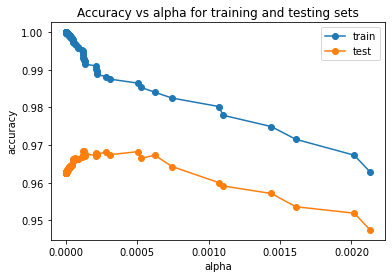

In [6]:
K=6  # number of largest values of alpha that are discarded; this allows better vizu of values of interest
train_scores = [clf.score(X_train, y_train) for clf in clfs[:-K]]
test_scores = [clf.score(X_test, y_test) for clf in clfs[:-K]]


plt.plot(ccp_alphas[:-K], train_scores, marker='o', label="train")
plt.plot(ccp_alphas[:-K], test_scores, marker='o', label="test")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Accuracy vs alpha for training and testing sets")

plt.legend()
plt.show()


## Question
- How could the score estimates be improved? 

### Finding the "optimal" $\alpha$ which maximizes the accuracy :

In [8]:
len(test_scores)

91

In [13]:
#alpha_opt=ccp_alphas(ccp_alpha == ccp_alphas.max())
accuracy=np.asarray(test_scores)
test_array=ccp_alphas[:-K]
alpha_opt=test_array[accuracy==accuracy.max()]
print(alpha_opt)

[0.00012366]


## ... and the winner regressor is : 

Number of nodes in clf_0 regressor :63
Training Accuracy of clf_0 regressor :0.9931895885567129
Testing Accuracy of clf_0 regressor :0.9683875819648934


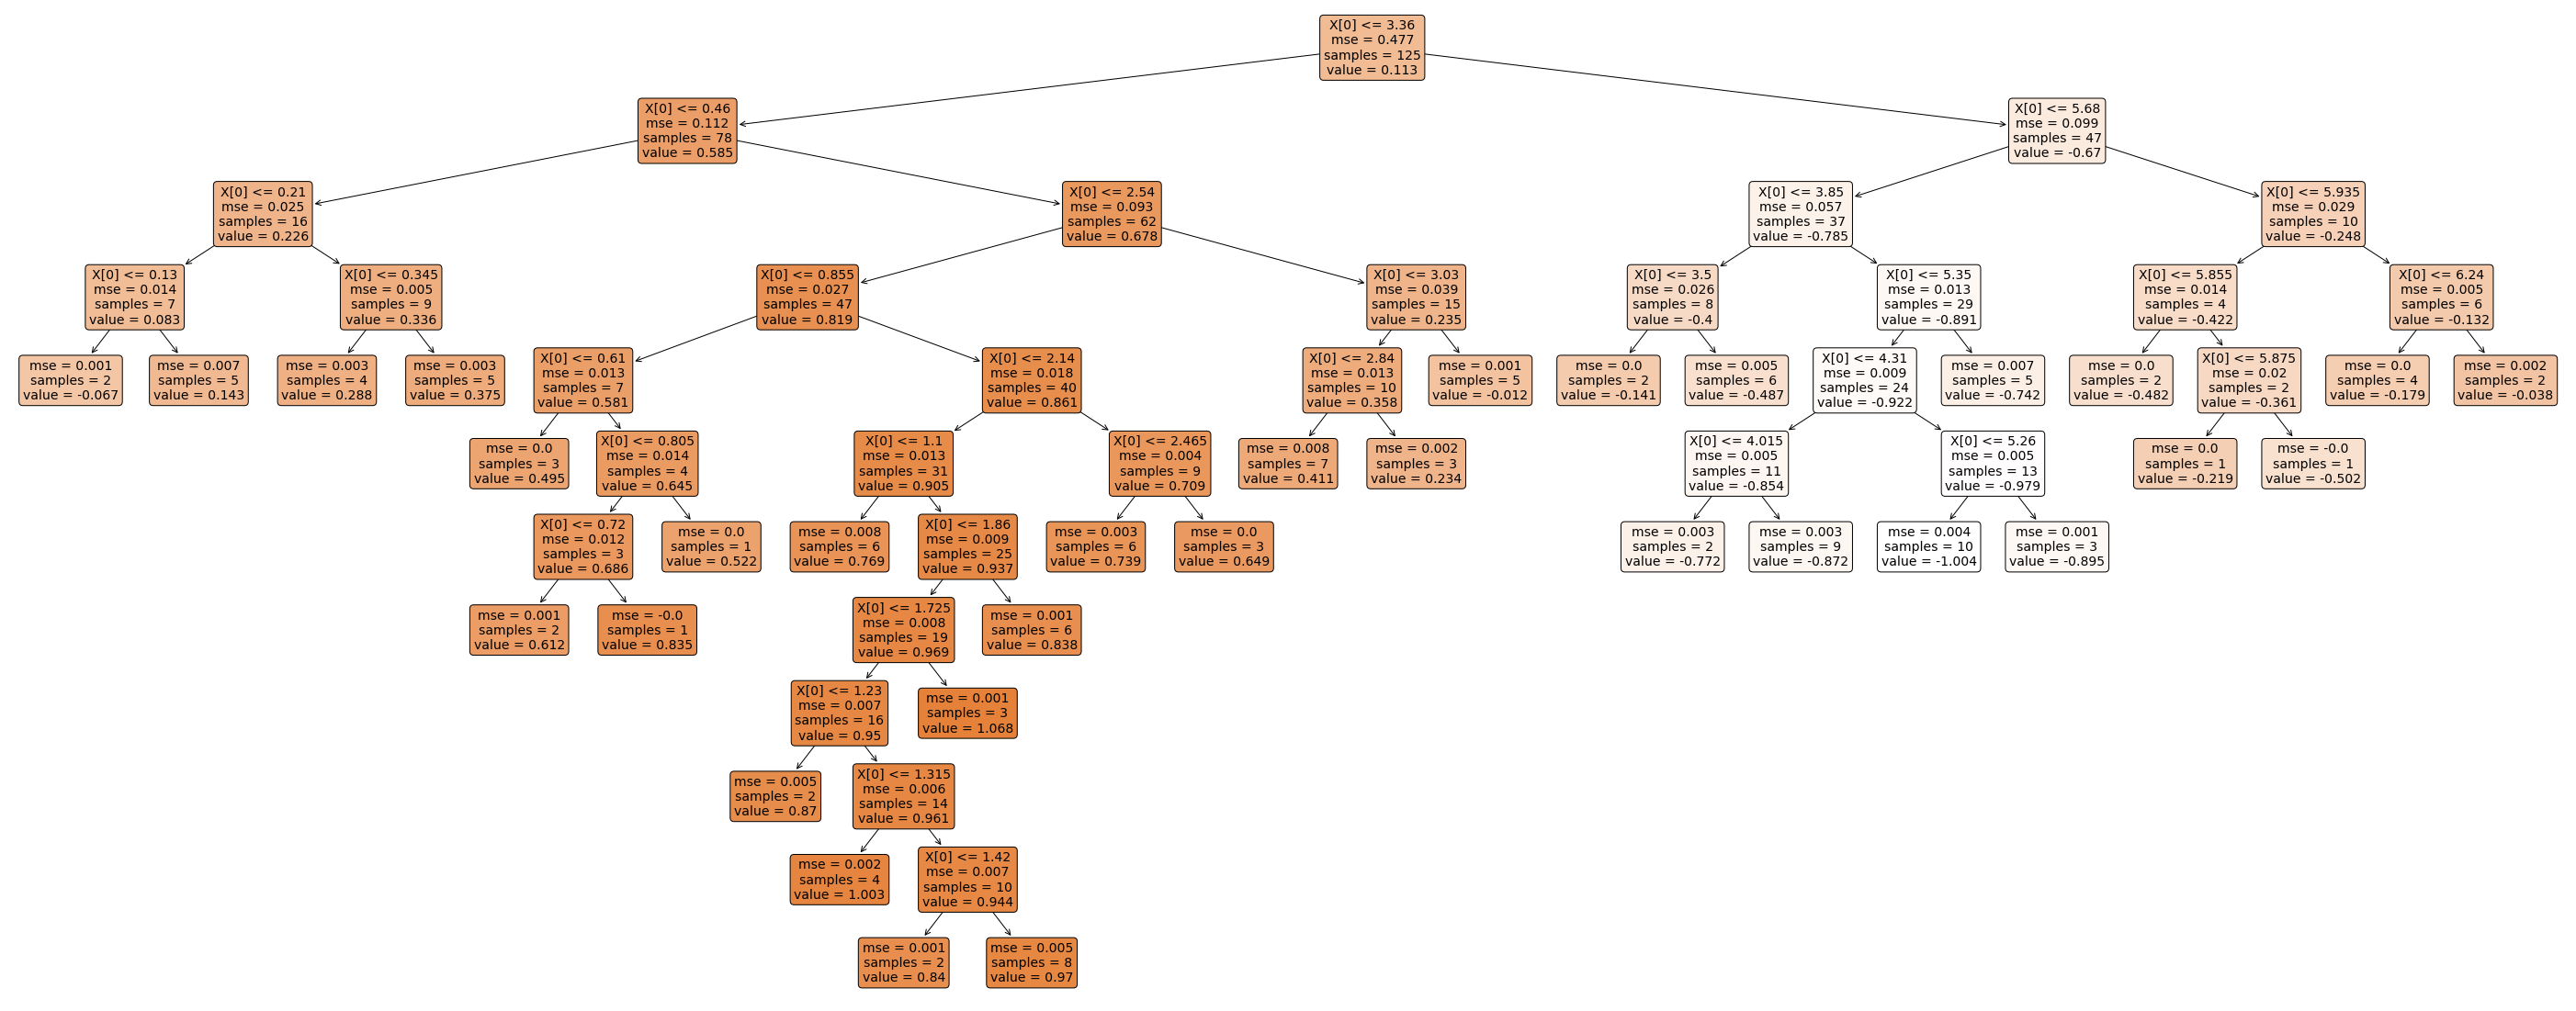

In [17]:
clf_0 = DecisionTreeRegressor(random_state=None, ccp_alpha=alpha_opt)  # other params take default values
clf_0 = clf_0.fit(X_train,y_train)

clf_0.tree_.node_count
print("Number of nodes in clf_0 regressor :{}".format(clf_0.tree_.node_count))
print("Training Accuracy of clf_0 regressor :{}".format(clf_0.score(X_train,y_train)))
print("Testing Accuracy of clf_0 regressor :{}".format(clf_0.score(X_test,y_test)))

plt.figure(figsize=(50,20))
a = plot_tree(clf_0, 
              filled=True, 
              rounded=True,fontsize=14)


## Comparison with the "best" solution from N2_a_Regression_tree notebook : 

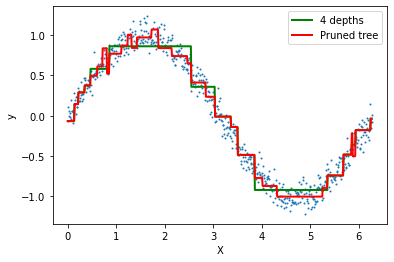

In [18]:
clf = DecisionTreeRegressor(random_state=0, criterion='mse', \
                           splitter='best', \
                           max_depth=4) 
clf.fit(X_train,y_train)


X_test = np.arange(0.0, X.max(), 0.01)[:, np.newaxis] #alternate method, to get a 2D array for 2D array from a scalar time series
# use the computed trees to obtain prediction values
y_p=clf.predict(X_test)
y_p_0=clf_0.predict(X_test)

plt.scatter(X,y,s=1)
plt.plot(X_test,y_p, color='green',label="4 depths", linewidth=2 )
plt.plot(X_test,y_p_0, color='red', label="Pruned tree",linewidth=2 )
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

## Question
- What is the biggest advantage of this tree pruning approach, if compared to tree growing with a prescribed  maximal depth? 


## Exercize
- Vary the SNR and analyse the behaviour of both the number of terminal leaves in the optimal tree, and the value of alpha_opt.